# Construcción de un pipeline de datos utilizando: tensorflow.data

## I. Introducción 

#### 1.1 Preliminares

El API de `tensorflow.data` permite manejar grandes cantidades de datos, leer desde diferentes fuentes de datos y realizar transformaciones complejas. Se brinda la abstraccón `tensorflow.data.Dataset` que representa una secuencia de elementos, en el que cada elemento consiste de uno o más componentes. Por ejemplo, si trabajamos en la construcción de un `pipeline` de imágenes, un elemento podría ser un ejemplo de entrenamiento, con un par de tensores representado la imagen y su etiqueta.

Podemos crear un dataset de dos formas:

*   Constuir el `Dataset` a partir de datos almacenados en memoria, o de uno o varios archivos. 
*   Construir el `Dataset` a partir de transformaciones realizadas sobre uno o más objetos `tensorflow.data.Dataset`.


Para construir un `pipeline` de datos, debemos partir de una **fuente de datos**:
 
*   Si queremos construir un `Dataset` a partir de datos en la memoria, podemos utilizar `tensorflow.data.Dataset.from_tensors()` o `tensorflow.data.Dataset.from_tensor_slices()`.

*   Si los datos se encuentran almacenados en un archivo con formato     `TFRecord`, podemos utilizar `tensorflow.data.Dataset.TFRecordDataset()`

Una vez que tengamos un objeto `Dataset`, podemos ***aplicar transformaciones*** para generar un nuevo `Dataset` encadenando llamadas a métodos en el objeto `tensorflow.data.Dataset`. Por ejemplo, podemos aplicar transformaciones por elemento utilizando `Dataset.map()`y transformaciones de varios elementos mediante `Dataset.batch()`.Para consultar la lista completa de transformaciones acceda al siguiente enlace: [transformaciones](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).


#### 1.2 Conjunto de datos

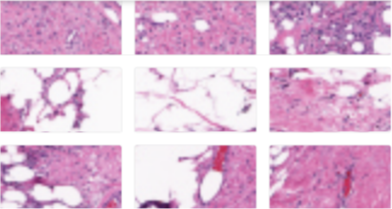

En nuestra actividad trabajaremos con el conjunto de datos Breast Histopathology Images que se encuentra disponible en Kaggle [[1]](https://www.kaggle.com/paultimothymooney/breast-histopathology-images).

Sin embargo, utilizaremos únicamente un [subconjunto](https://iteso01-my.sharepoint.com/:f:/g/personal/fcervantes_iteso_mx/Es7gRyI804JOrKjCPkTw1BQBbPwRw5U97MJmuHKITJhOFA?e=8O0wiv) de los datos con propósitos didácticos en la construcción del `pipeline`.

Al descargar los datos y descomprimir el archivo observará una estructura de directorios similar a:

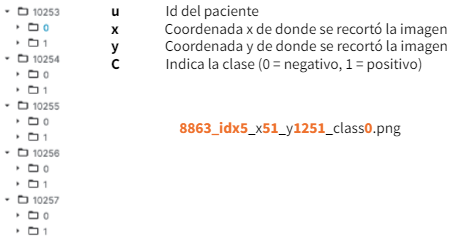

Las imágenes tienen dimensiones (50, 50, 3) y los nombre de los archivos siguen el formato: **u**x**X**y**Y**class**C**.png 

## 2. Descripción de la actividad

El objetivo principal de la actividad es construir un `pipeline` de datos basado en `tensorflow.data.Dataset`. Sin embargo, antes de iniciar con la construcción del `pipeline` es conveniente crear los conjuntos de datos de entrenamiento, validación y prueba.

**Actividad 1**

Construyamos  una función que organice el conjunto de imágenes de entrada para entrenamiento, validación y prueba. Para esto la función  recibirá como parámetros:


*   Ruta en donde se encuentran los datos originales.
*   Ruta en donde serán almacenados las imágenes  de entrenamiento, validación y pruebas.
*   El porcentaje de datos que serán utilizados para entrenamiento.
*   El porcentaje de datos que serán utilizados para validación.

En la siguiente imagen puede ver un ejemplo de la organización de archivos que se espera genere nuestra función:


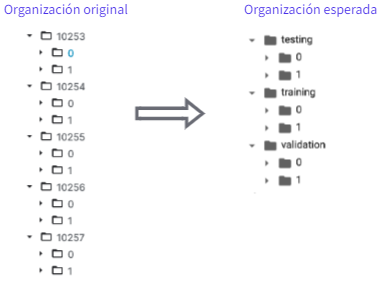

In [1]:
# Librerías y módulos que necesitaremos en la actividad
from imutils import paths
import random
import shutil
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Dropout

In [2]:
# Función que genera la organización esperada de nuestros ejemplos de entrenamiento

def organize_data(src_path, dst_path, train_split=.9, val_split=0.1):
  # Determinemos la ruta para los datasets de entrenamiento, validación y pruebas
  train_path = os.path.sep.join([dst_path, "training"])
  val_path = os.path.sep.join([dst_path, "validation"])
  test_path = os.path.sep.join([dst_path, "testing"])
  
  # lista de imágenes en la ruta origen
  img_paths = list(paths.list_images(src_path))
  random.seed(30)
  random.shuffle(img_paths)
  s = int(len(img_paths)*train_split)
  train_img_paths = img_paths[:s]   # listado de rutas de imágenes para entrenamiento
  test_img_paths = img_paths[s:]    # listado de rutas de imágenes para pruebas
  
  #Crear listado de rutas de imágenes para validación (subconjunto del dataset de entrenamiento)
  s = int(len(train_img_paths)*val_split)
  val_img_paths = train_img_paths[:s]     # listado de rutas de imágenes para validación
  train_img_paths = train_img_paths[s:]   # listado de rutas de imágenes para entrenamiento
  
  datasets = [
      ("training", train_img_paths, train_path),
      ("validation", val_img_paths, val_path),
      ("testing", test_img_paths, test_path)
      ]
  
  for (dType, img_paths, dst_path) in datasets:
    print(f"Creación del conjunto de datos: {dType}")
    # Existe el directorio destino, sino entonces crearlo
    if not os.path.exists(dst_path):
      print(f"Creando el directorio: {dst_path}")
      os.makedirs(dst_path)
    
    # Recorramos las rutas de las imágenes
    for input_path in img_paths:
      #Extraer el nombre de la imagen y la clase a la que pertenece
      filename = input_path.split(os.path.sep)[-1]
      label = filename[-5:-4]
      
      label_path = os.path.sep.join([dst_path, label])

      # Verifiquemos si el directorio existe, si no hay que crearlo
      if not os.path.exists(label_path):
        print(f"Creando el directorio: {label_path}")
        os.makedirs(label_path)
      
      # Construir el path destino de la imagen y copiarla
      p = os.path.sep.join([label_path, filename])
      shutil.copy2(input_path, p)
  return train_img_paths, val_img_paths, test_img_paths

In [3]:
# Probemos el funcionamiento correcto de nuestra función

src_path = "/content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data"
dst_path = "/content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst"

train_paths, val_paths, test_paths=organize_data(src_path, dst_path, 0.8, 0.1)

Creación del conjunto de datos: training
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/training
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/training/1
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/training/0
Creación del conjunto de datos: validation
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/validation
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/validation/1
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/validation/0
Creación del conjunto de datos: testing
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/testing
Creando el directorio: /content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/testing/0
Creando el directorio: /content/drive/

Ahora que tenemos organizadas las imágenes, es conveniente implementar algunas funciones que nos permitan: cargar imágenes, aumentar los datos, etc.

***Actividad 2*** 

Implementemos una función que nos permite cargar imágenes y generar sus etiquetas. La función debe recibir como parámetro la dirección donde se encuentra almacenada una imagen y las dimensiones deseadas.

La función deberá retornar una tupla: (imagen, etiqueta)

In [4]:
def loadImage(img_path, shape=(32, 32)):
  # Leamos la imagen, decodificarla, convertir el tipo de datos a float32, y redimensionar la imagen
  img = tf.io.read_file(img_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32) # int-8 --> float32
  img = tf.image.resize(img, shape)

  # Extraer la etiqueta de la clase
  label = tf.strings.split(img_path, os.path.sep)[-2]
  label = tf.strings.to_number(label, tf.int32)
  return (img, label)

In [5]:
img_path = "/content/drive/MyDrive/DL2023p-licd/S04/breast_histopathology_data/dst/training/0/8863_idx5_x101_y1201_class0.png"
(img, label) = loadImage(img_path, (28, 28))

In [6]:
print(label)
print(img)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(
[[[0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9663316 ]
  ...
  [0.9630803  0.9607844  0.96470594]
  [0.9607844  0.9607844  0.96470594]
  [0.9607844  0.96171975 0.96470594]]

 [[0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9686275 ]
  ...
  [0.9614847  0.9607844  0.96470594]
  [0.9614847  0.9607844  0.96470594]
  [0.9614847  0.9607844  0.96470594]]

 [[0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9686275 ]
  [0.96470594 0.96470594 0.9686275 ]
  ...
  [0.96470594 0.9607844  0.96470594]
  [0.96470594 0.9607844  0.96470594]
  [0.96470594 0.9607844  0.96470594]]

 ...

 [[0.83623964 0.48550427 0.6205782 ]
  [0.8078732  0.34815922 0.4967487 ]
  [0.8005653  0.41157976 0.5667919 ]
  ...
  [0.96470594 0.9607844  0.96470594]
  [0.96470594 0.9638906  0.9678122 ]
  [0.96619153 0.96226996 0.96848744]]

 [[0.80057526 0.417032   0.

***Actividad 3***

Ahora implementemos una función que nos permita realizar el aumento de datos, es decir generar nuevas imágenes a partir de las originales. A manera de ejemplo, utilizaremos dos transformaciones: un flip vertical y un ajuste de iluminación en la imágen.

La función deberá retornar una tupla: (nueva_imagen, etiqueta)

In [7]:
def image_aumentation(img, label):
  # Realicemos flip horizontal y ajustemos la iluminación
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_brightness(img, 0.3)
  return (img, label)

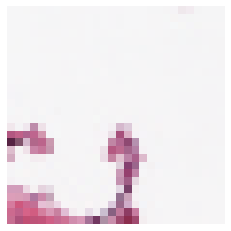

In [8]:
plt.axis('off')
plt.imshow(img.numpy())

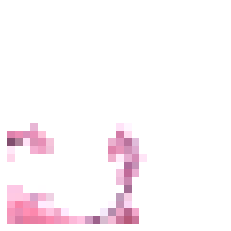

In [9]:
(img1, label1) = image_aumentation(img, label)
plt.axis('off')
plt.imshow(img1.numpy())

Es momento de construir el pipeline para los datos de entrada que serán alimentados en el modelo durante las etapas de entrenamiento y validación.

***Actividad 4***

Para implementar los generadores de datos para los dataset de entrenamiento, validación y pruebas,  utilizaremos el módulo `tensorflow.data.Dataset.from_tensor_slices`.

Para nuestra actividad, los pipelines incluirán:


1.   Barajear todas las rutas de imágenes (para el dataset de entrenamiento)
2.   Cargar las imágenes en el buffer
3.   Aplicar el automento de datos (para el dataset de entrenamiento)
4.   Almacenar en caché el resultado para lecturas posteriores
5.   Crear un lote de datos
6.   Permitir el `prefetch` para optimizar la rutina en segundo plano




In [10]:
batch_size = 28
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = (train_dataset
                 .shuffle(len(train_paths))
                 .map(loadImage, num_parallel_calls=AUTOTUNE)
                 .map(image_aumentation, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

In [11]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = (val_dataset
               .shuffle(len(val_paths))
               .map(loadImage, num_parallel_calls=AUTOTUNE)
               .cache()
               .batch(batch_size)
               .prefetch(AUTOTUNE)
               )

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = (test_dataset
                 .map(loadImage, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

***Actividad 5***

Ahora que tenemos listos nuestros `pipelines` para los datos de entrada, probemos su correcto funcionamiento. Para esto necesitamos definir un modelo X. Para la actividad, se propone contruir una ConvNet con las sigueintes capas:

*  Capa de entrada con dimensiones de datos de entrada acorde a lo determinado en las actividades previas.

*  Capa convolucional,  kernel=(3, 3), filtros=6, activación = ReLU

*  Capa Pooling

*  Capa convolucional,  kernel=(3, 3), filtros=16, activación = ReLU

*  Capa Pooling

*  Capa Flatten

*  Capa Densa, neuronas= 128, activación = ReLU

*  Capa BatchNormalization

*  Capa Dropout, 50%

*  Capa Dense, neuronas=1, activación = sigmoidal, bias = 0

In [13]:
model = keras.Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(AveragePooling2D())
    
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())
    
model.add(Dense(128, activation ="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Clasificación binaria
model.add(Dense(1, activation="sigmoid"))

Es momento de definir: loss, optimizer y metrics para nuestro modelo. Para el entrenamiento, se sugiere iniciar con pocas epocas.

In [14]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy"])

## Uso de Callbacks en Keras

Para la etapa de entrenamiento de nuestro modelo, utilizaremos a manera de ejemplo los callbacks:

*   ModelCheckpoint
*   EarlyStopping

In [15]:
# Configuración del callback ModelCheckpoint

checkpoint_filepath='/content/drive/MyDrive/DL2023p-licd/S04/myModels/checkpointX'
my_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

my_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1, patience=3)

modelX = model.fit(train_dataset, epochs = 15, validation_data = val_dataset, callbacks=[my_checkpoint_callback, my_earlystopping_callback])




Epoch 1/15
7/7 [==============================] - 5s 281ms/step - loss: 0.7218 - accuracy: 0.5765 - val_loss: 0.6115 - val_accuracy: 0.6667
Epoch 2/15
7/7 [==============================] - 0s 39ms/step - loss: 0.5796 - accuracy: 0.6765 - val_loss: 0.5953 - val_accuracy: 0.6667
Epoch 3/15
7/7 [==============================] - 0s 52ms/step - loss: 0.5477 - accuracy: 0.7059 - val_loss: 0.5844 - val_accuracy: 0.6667
Epoch 4/15
7/7 [==============================] - 0s 45ms/step - loss: 0.4361 - accuracy: 0.8059 - val_loss: 0.5725 - val_accuracy: 0.6667
Epoch 5/15
7/7 [==============================] - 1s 89ms/step - loss: 0.4302 - accuracy: 0.8059 - val_loss: 0.5990 - val_accuracy: 0.8333
Epoch 6/15
7/7 [==============================] - 0s 64ms/step - loss: 0.2988 - accuracy: 0.8941 - val_loss: 0.5721 - val_accuracy: 0.7778
Epoch 7/15
7/7 [==============================] - 0s 68ms/step - loss: 0.3278 - accuracy: 0.8647 - val_loss: 0.6007 - val_accuracy: 0.8333
Epoch 8/15
7/7 [==========

In [17]:
#Almacenar el modelo completo en formato H5 (Keras)
checkpoint_path = "/content/drive/MyDrive/DL2023p-licd/S04/myModels/checkpointX"
saved_wX = model.load_weights(checkpoint_path)  #Cargar pesos